In [1]:
#pool = ThreadPool(4) # Sets the pool size to 4

In [2]:
#pool_graph = pool.starmap(nx.erdos_renyi_graph, zip(repeat(mc_sim), prob_grid))
#pool_matr = pool.map(nx.adj_matrix, pool_graph)
#results_irr = pool.map(isconnected_irreducibility2, pool_matr)

In [3]:
#results_lap = list(repeat(pool.map(isconnected_laplace2, pool.map(nx.laplacian_matrix, pool.starmap(nx.erdos_renyi_graph, zip(repeat(mc_sim), prob_grid)))),100))

In [4]:
#results_irr = list(repeat(pool.map(isconnected_irreducibility2, pool.map(nx.adj_matrix, pool.starmap(nx.erdos_renyi_graph, zip(repeat(mc_sim), prob_grid)))),100))

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time
from itertools import repeat
import heapq as hp
#from multiprocessing import Pool
#from multiprocessing.dummy import Pool as ThreadPool
from scipy.stats import bernoulli
import random
import copy
from itertools import combinations
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors as mcolors
import warnings
warnings.filterwarnings("ignore")

In [6]:
sall = time.time()

# Functions

In [7]:
def stopWatch(value):
    '''From seconds to Days;Hours:Minutes;Seconds'''

    valueD = (((value/365)/24)/60)
    Days = int (valueD)

    valueH = (valueD-Days)*365
    Hours = int(valueH)

    valueM = (valueH - Hours)*24
    Minutes = int(valueM)

    valueS = (valueM - Minutes)*60
    Seconds = int(valueS)


    print (Days,";",Hours,":",Minutes,";",Seconds)

##### Function to check connection via irreducibility

In [8]:
def isconnected_irreducibility (adj_matrix):
    
    # convert the csr sparse matrix an bidimensional array
    adj_matrix = adj_matrix.asformat("array")
    
    # initialize the identity matrix
    sum_adj = np.identity(len(adj_matrix))
    # build the auxiliray matrix to speed up the calculations
    aux = np.identity(len(adj_matrix))
    
    # build the matrix to check at the end
    for i in range(1,len(adj_matrix[0])):
        aux = np.matmul(aux,adj_matrix)
        sum_adj = np.add(sum_adj, aux)

    # check if all the final components of the matrix are grater than zero
    if sum_adj.all()>0:
        return(1)
    else:
        return(0)

##### Function to chech connection via laplace matrix

In [9]:
def isconnected_laplace(lapl_matrix):
    lapl_matrix = lapl_matrix.asformat("array")
    eigenvls = sum( np.round(np.linalg.eigvals(lapl_matrix),3) >0 )
    if (eigenvls > len(lapl_matrix[0])-2):
        return(1)
    else:
        return(0)

##### Breadth First Search

In [10]:
def bfs (G, root):
    
    # define pop and push actions for the queue
    push = hp.heappush
    pop = hp.heappop
    
    # the function g.adj what actually does is return the neighbors of a node and the weigths of the edges
    G_neighbors = G.adj
    
    # initialize the queue with the root node inside and transform it in a heap queue
    queue = [root]
    hp.heapify(queue)
    # visited is a dictionary where we are gonna store all the nodes reachable from the root
    visited = {}    

    # until the queue is not empty
    while queue:
        # pick out the last/first value inserted
        vertex = pop(queue)    
        # store it in the visited nodes
        visited[vertex] = "true"  
        # start looking at the neighbors of the nodes 
        # NB G.neighbors[vertex].items() gives a dictonary of nodes and weights of the edges
        for neighbor, weight in G_neighbors[vertex].items():
            # if the node has not been visited yet..
            if (neighbor not in visited.keys()):
                # and it is not already in the queue..
                if (neighbor not in queue):
                    # push it inside the queue
                    push(queue, neighbor)
    
    # if all the nodes reachable from the root are all the nodes of the graph
    if len(visited) == len(G.nodes()):  
        # the graph is connected
        return(1)
    else:
        # not connected otherwise
        return(0) 

##### Erdos Renyi graph function

In [11]:
def erdos_renyi(n, p):
    # initialize the adjacency matrix with all 0s
    mat = np.zeros((n,n))
    
    # check the upper triangular part of the matrix 
    for i in range(n):
        for j in range(i+1, n):
            # bernoulli trial with prob p to add (or not) and edge
            if(bernoulli.rvs(p)==1):
                mat[i][j]=1
                mat[j][i]=1
    # convert adj matr into a graph
    G = nx.from_numpy_matrix(mat)
    return(G)

##### Regular Random graph function

In [12]:
def rr_graph(n,r):
    #creating a list with all the nodes that don't have degree r
    l = [i for i in range(n)]
    #initializing the degree of all nodes to 0
    complete = [0 for i in range(n)]
    #initializing the adjacency matrix to 0
    adj=np.zeros((n,n))
    
    for i in range(n):
        for k in range(n):
            #for every possible neighbour of i
            if k in l:
                #we check if the degree of the possible neighbour is still less than the degree wanted(r)
                if complete[k]==r:
                    #if it's r we remove it because this one has the maximum neighbours it could have
                    l.remove(k)
        #we generate a copy of the list of possible neighbours
        aux = copy.copy(l)
        if i in aux:
            #we delete the node i because we don't want to connect it with itself
            aux.remove(i)
            #while the degree of the node i is not r and we still have a possible neighbour
            while complete[i]!=r and len(aux)>0:
                try: 
                    #we choose one neighbour randomly
                    choice = np.random.choice(aux)
                    #we add the edge to our adjacency matrix
                    adj[i,choice]= 1
                    adj[choice,i]=1
                    #we add one to degree each node has
                    complete[i]+=1
                    complete[choice]+=1
                    #we remove the neighbour of the list of possible neighbours because it is already one
                    aux.remove(choice)
                except: 
                    return(rr_graph(n,r))
    #returning the graph we generated
    G = nx.from_numpy_matrix(adj)
    return(G)


##### Function to get information of a given graph

In [13]:
def my_information(g):
    
    isolated_nodes, len_shortest_paths, number_paths = 0, 0, 0
    info = {}
    degrees = []
    shortest_path = {}
    
    # initialize empty list for shortest paths between nodes
    for i,j in combinations(g.nodes(),2):
        shortest_path[i,j]=[]
        shortest_path[j,i]=[]
        
    # n of edges
    info["links"] = len(g.edges())
    #n of nodes
    info["nodes"] = len(g.nodes())
    # laplacian matrix of the graph
    #lapl_matrix= nx.laplacian_matrix(g)
    
    #check if it's connected
    info["connected"] = (bfs(g,0)==1)
    
    for component in nx.connected_component_subgraphs(g):
        for x in list(dict(component.degree(component.nodes())).values()):
            degrees.append(x)
            
        if len(component.nodes()) == 1:
            isolated_nodes += 1
        else:
            for source, target in combinations(component.nodes(), 2):
                #find the shortest path routes
                shortest_path[source,target]= nx.shortest_path(component, source, target)
                shortest_path[target,source]= shortest_path[source,target][::-1] 
                len_shortest_paths += (len(shortest_path[source,target])-1)
                number_paths += 1
                
    #estimate h_hat (average path length)          
    info["average_path_length"] = len_shortest_paths*1.0/number_paths
    info["average_degree"] = sum(degrees)/info["nodes"]
    info["my_paths"]=shortest_path
    info["v_flow"] = number_paths
    return(info)

In [14]:
#Generating our own function in order to understand what nx does
def build_paths(start_node):
    dist = {}
    for node in nodes:
        if node == start_node:
            dist[node] = (0, node)
        else:
            dist[node] = (float('inf'), None)
    return dist
        
        
def shortest_paths(node_a):
    # Dijkstra's algorithm with edge_weights set to 0 and implementation of priority queue
        dist = build_paths(node_a)
        edge_weight = 1
        visited_nodes = set()
        nodes_to_visit = [(0, node_a, [])]
        while len(nodes_to_visit) > 0:
            c_node = heapq.heappop(nodes_to_visit)
            if c_node[1] in visited_nodes : continue

            for adj_node in neighbours[c_node[1]]:
                new_distance = c_node[0]  + edge_weight
                old_distance = dist[adj_node][0]
                if new_distance < old_distance:
                    dist[adj_node] = (new_distance, c_node[1], c_node[2] + [adj_node])
                    heapq.heappush(nodes_to_visit, (new_distance, adj_node, c_node[2] + [adj_node]))

        return dist


#### Function to better visualize the plots

In [15]:
def draw_graph(graph, title):
    # node size and colour depend on node degree
    plt.figure(figsize=(20, 10))
    ax = plt.gca()
    ax.set_title(str(title).title())
    sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette((max([graph.degree(node) for node in graph.nodes()])),
                                                          rot = -0.3, dark = 0.1, as_cmap=True), norm=plt.Normalize(vmax=1, vmin=5))
    sm._A = []
    
    color_palette = sns.cubehelix_palette((max([graph.degree(node) for node in graph.nodes()])), rot = -0.3, dark = 0.1)
    cmap = {node : color_palette[degree-1] for node, degree in zip((node for node in graph.nodes()), (graph.degree(node) for node in graph.nodes()))}
    node_sizes = [graph.degree(node)*30 if node > 15 else graph.degree(node)*15 for node in graph.nodes()]
    
    # create a colorbar
    max_tick = max([graph.degree(node) for node in graph.nodes()])
    incr = max_tick//5
    cbar = plt.colorbar(sm, ticks=range(6))
    cbar.ax.set_yticklabels([1, 1+incr, max_tick//2, (max_tick//2)+incr, max_tick])
    cbar.set_label("Node Degree", rotation=270)
    
    nx.draw(graph, k=0.2, node_size = node_sizes, alpha = 0.9, edge_color= "grey", node_color = [cmap[node] for node in graph.nodes()])
    return plt.show()

def draw_subplot(title,  xlabel, ylabel, n_list, list1, label1, list2, label2, list3=None, label3=None):
    
    fig, ax = plt.subplots(figsize=(18,9))
    ax.plot(n_list, list1, label=str(label1).title(), marker="o", color="green")
    ax.plot(n_list, list2, label=str(label2).title(), marker="o", color="blue")
    if list3 and label3:
        ax.plot(n_list, list3, label=str(label3).title(), marker="o", color="red")
    ax.set(xlabel=xlabel, ylabel=ylabel, title=str(title).title())
    plt.legend()
    for number in n_list:
        plt.axvline(x=number, color="darkgrey", linestyle="dashed")
    return plt.show()

def draw_subplot4(title, xlabel, ylabel, n_list, list1, label1, list2, label2, 
                  list3=None, label3=None, list4=None, label4=None):
    
    fig, ax = plt.subplots(figsize=(18,9))
    
    ax.plot(n_list, list1, label=str(label1).title(), marker="o", color="green")
    ax.plot(n_list, list2, label=str(label2).title(), marker="o", color="blue")
    if list3.any() and label3:
        ax.plot(n_list, list3, label=str(label3).title(), marker="o", color="red")
    if list4.any() and label4:
        ax.plot(n_list, list4, label=str(label4).title(), marker="*", linestyle="--", color="yellow")
    
    ax.set(xlabel=xlabel, ylabel=ylabel, title=str(title).title())
    
    ax.legend(loc = "lower left")
    
    for number in n_list:
        plt.axvline(x=number, color="darkgrey", linestyle="dashed")
    return plt.show()

##### Function to retrieve the shortest path between source and destination given by the user

In [16]:
def tell_me_the_path(x,y, info):
    l =info["my_paths"][x,y]
    if (len(l)==0):
        print("so sorry, this path does not exist: THEY ARE NOT CONNECTED")
    elif (len(l)==2):
        print("they are directed connected!")
    else:
        print("For going from ", x, " to ", y, " you should follow this path: ", l)

##### Function to simulate edge failure

In [17]:
def failure (g, q,n):
    adj_matr = nx.adjacency_matrix(g).asformat("array")
    for i in range(n):
        for j in range(i,n):
            if adj_matr[i][j]==1:
                if (bernoulli.rvs(q)==1):
                    adj_matr[i][j] = 0
                    adj_matr[j][i] = 0
                    
    return(nx.from_numpy_matrix(adj_matr))

#### 1)

In [18]:
# p_ER graph with 50 nodes and probability of nodes = 0.2
ER = erdos_renyi(n = 50, p = 0.2) 

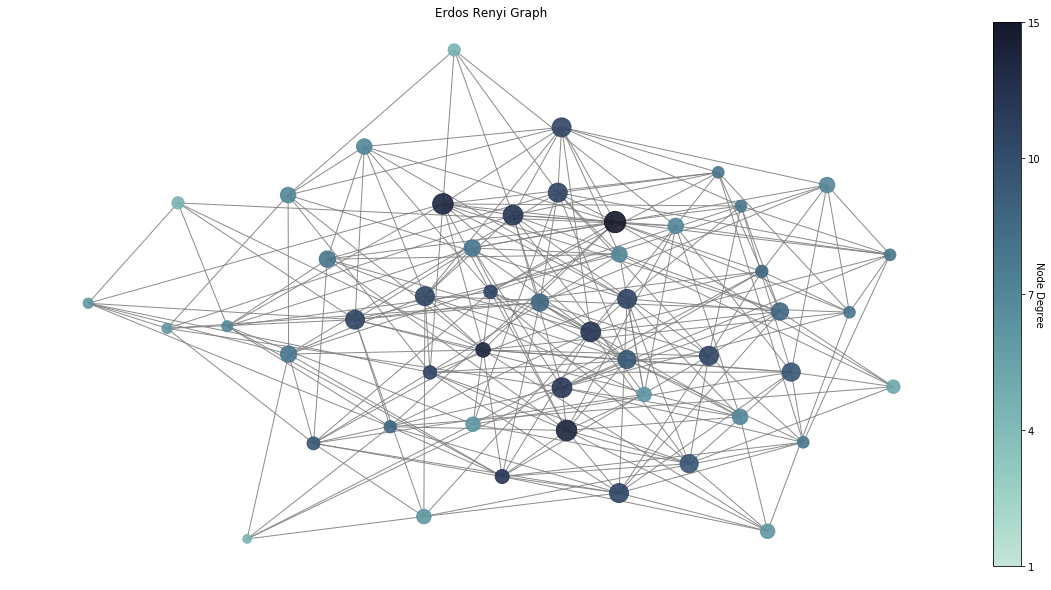

In [19]:
# plotting the p_ER graph
draw_graph(ER, "erdos renyi graph")

#### 2)

In [20]:
# create a regular random graph with degree 9 and 500 points
RR= rr_graph(100, 2)

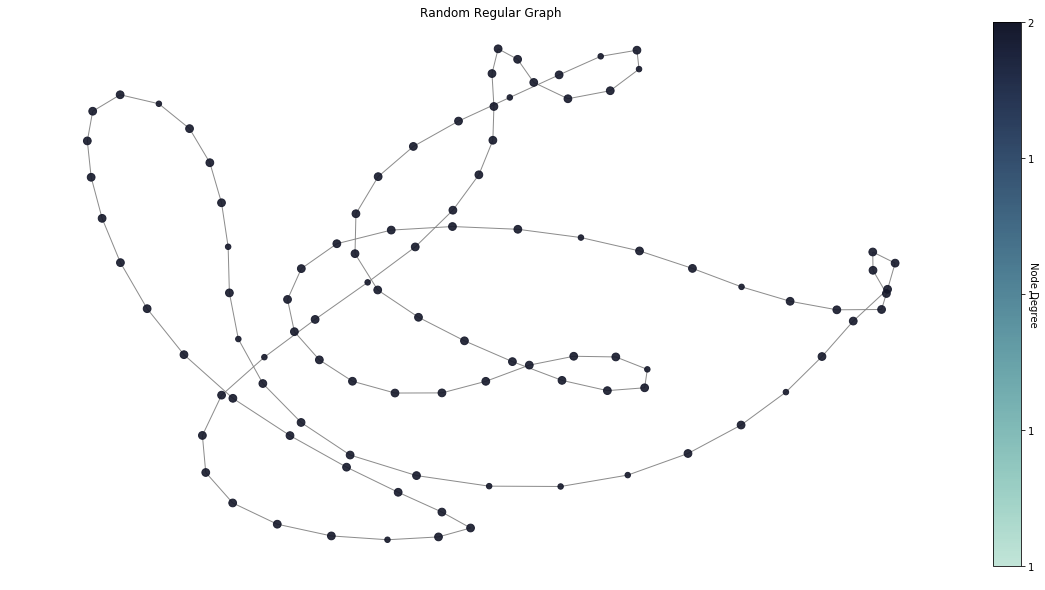

In [21]:
# plotting R
draw_graph(RR, "random regular graph")

###### All nodes have the same colour >> the colour reflects the degree of each node, and in the random regular graph all nodes have the same (input) degree

In [22]:
# Erdos Renyi matrices
lER = nx.laplacian_matrix(ER)
adj_ER = nx.adjacency_matrix(G=ER)

In [23]:
# Regular Random matrices
lRR = nx.laplacian_matrix(RR)
adj_RR = nx.adjacency_matrix(G=RR)

#### 3)

In [24]:
# connectivity check for RR graph
print("CONNECTIVITY CHECK FOR RR GRAPH")
print('{}{}'.format( "connectivity check via irriducibility:     ",isconnected_irreducibility(adj_RR))) 
print('{}{}'.format( "connectivity check via laplacian eigenvls: ",isconnected_laplace(lRR)))               
print('{}{}'.format( "connectivity check via bfs:                ",bfs(RR,0)))

CONNECTIVITY CHECK FOR RR GRAPH
connectivity check via irriducibility:     1
connectivity check via laplacian eigenvls: 1
connectivity check via bfs:                1


In [25]:
# connectivity check for p_ER
print("CONNECTIVITY CHECK FOR ER GRAPH")
print('{}{}'.format( "connectivity check via irriducibility:     ",isconnected_irreducibility(adj_ER)))
print('{}{}'.format( "connectivity check via laplacian eigenvls: ",isconnected_laplace(lER)))               
print('{}{}'.format( "connectivity check via bfs:                ",bfs(ER,0)))

CONNECTIVITY CHECK FOR ER GRAPH
connectivity check via irriducibility:     1
connectivity check via laplacian eigenvls: 1
connectivity check via bfs:                1


##### 4)

In [26]:
# to calculate computational time

# initialize list that will syore computational time for laplacian, irreducibility and bfs connectivity check
L_time =[]
IRR_time = []
BFS_time=[]

# build a grid of nodes for the graphs
nodes_list = np.arange(10,210,10)

for i in nodes_list:
    # building erdso renyi with fixed prob=0.2
    g = erdos_renyi(n=i,p=0.2)
    
    #laplace
    stime = time.time()
    isconnected_laplace(nx.laplacian_matrix(g))
    etime = time.time() - stime
    L_time.append(etime)
    
    # irreducibility
    stime2 = time.time()
    isconnected_irreducibility(nx.adj_matrix(g))
    etime2 = time.time() - stime2
    IRR_time.append(etime2)
    
    # bfs
    stime3 = time.time()
    bfs(g,0)
    etime3 = time.time() - stime3
    BFS_time.append(etime3)
        


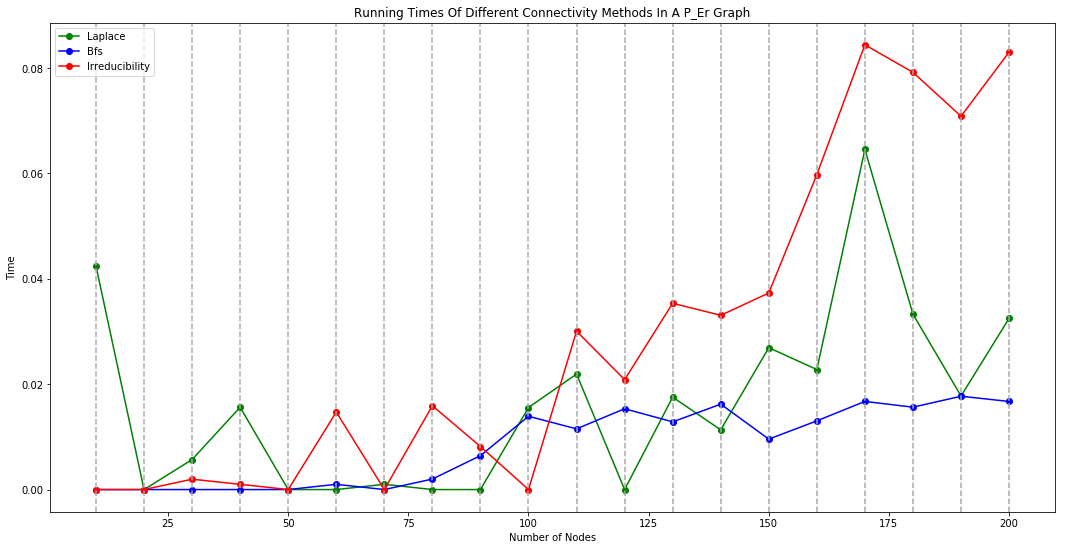

In [27]:
# plot all three connectivity times
draw_subplot("Running times of different connectivity methods in a p_ER graph", "Number of Nodes", "Time",
             nodes_list, L_time, "Laplace", 
             BFS_time, "BFS", 
             IRR_time, "Irreducibility")

In [28]:
# to calculate computational time

# initialize list that will syore computational time for laplacian, irreducibility and bfs connectivity check
L_time =[]
IRR_time = []
BFS_time=[]

# build a grid of nodes for the graphs
n_list = np.arange(10,210,10)

for i in n_list:
    # building erdso renyi with fixed prob=0.2
    g = rr_graph(i, 4)
    
    #laplace
    stime = time.time()
    isconnected_laplace(nx.laplacian_matrix(g))
    etime = time.time() - stime
    L_time.append(etime)
    
    # irreducibility
    stime2 = time.time()
    isconnected_irreducibility(nx.adj_matrix(g))
    etime2 = time.time() - stime2
    IRR_time.append(etime2)
    
    # bfs
    stime3 = time.time()
    bfs(g,0)
    etime3 = time.time() - stime3
    BFS_time.append(etime3)

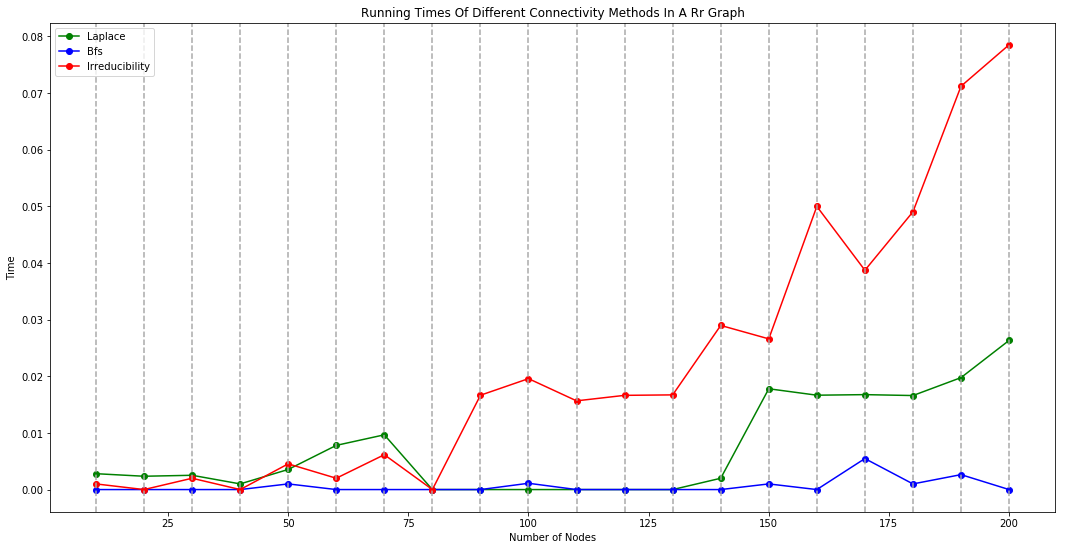

In [29]:
draw_subplot("Running times of different connectivity methods in a RR graph", "Number of Nodes", "Time",
             nodes_list, L_time, "Laplace", 
             BFS_time, "BFS", 
             IRR_time, "Irreducibility")

#### 5) simulation Erdos Renyi

In [30]:
start = time.time()

# montecarlo simulation size
mc_sim = 100

# probability grid
prob_grid = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.4, 0.6, 0.8, 1]

# array to store results from connectivity check
results = np.zeros(shape=(15))

# montecarlo to fill up the vectors
for i in range(0,len(prob_grid)):    
    for j in range(0,mc_sim):
        g = erdos_renyi(n=100, p=prob_grid[i])
        results[i] += bfs(g,0)
 
        
end = time.time()
stopWatch(end-start)

0 ; 0 : 9 ; 47


#### 5) simulation Random Regular

In [31]:
start = time.time()

# montecarlo simulation size
mc_sim = 100

# probability grid
nodes_grid = np.arange(10, 110, 10)
r_grid = [2,4,8,16]

# matrix to store results from connectivity check
results_rr = np.zeros(shape=(4,10))


# montecarlo to fill up the matrices
for i in range(len(r_grid)):
    for j in range(len(nodes_grid)):
        sum_rr = 0
        for z in range(mc_sim):
            g = rr_graph(nodes_grid[j],r_grid[i])
            sum_rr += bfs(g,0)
        results_rr[i][j] = sum_rr

end = time.time()
stopWatch(end-start)

0 ; 0 : 0 ; 40


##### Plot of Erdos Erdos Renyi and P(connected)

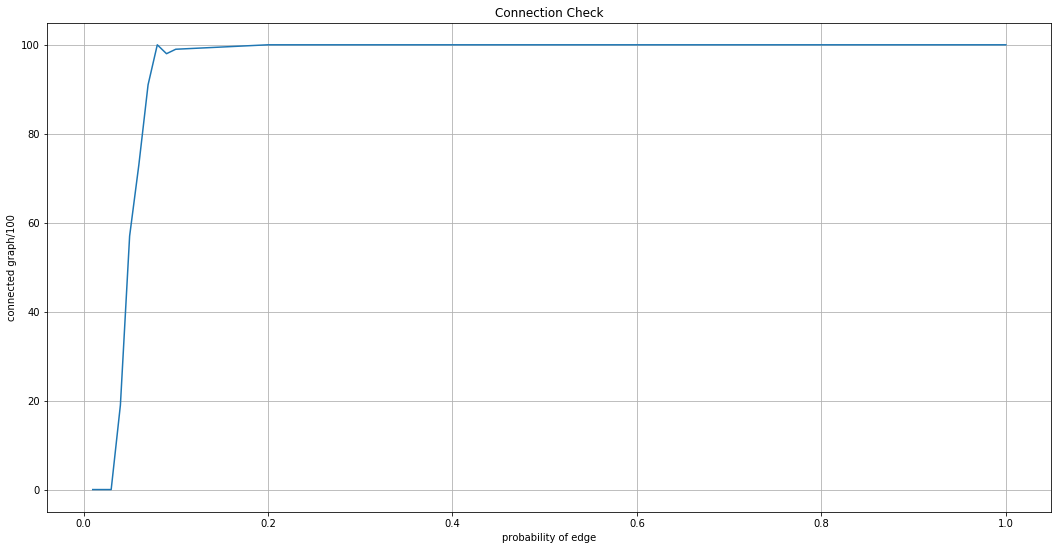

In [32]:
# plotting the results for p_ER graph - Irreducibility + Laplacian Eigenvalues
plt.figure(figsize=(18,9))
plt.plot(prob_grid, results)
plt.title('Connection Check')
plt.xlabel('probability of edge')
plt.ylabel('connected graph/100')
plt.grid()

plt.show()

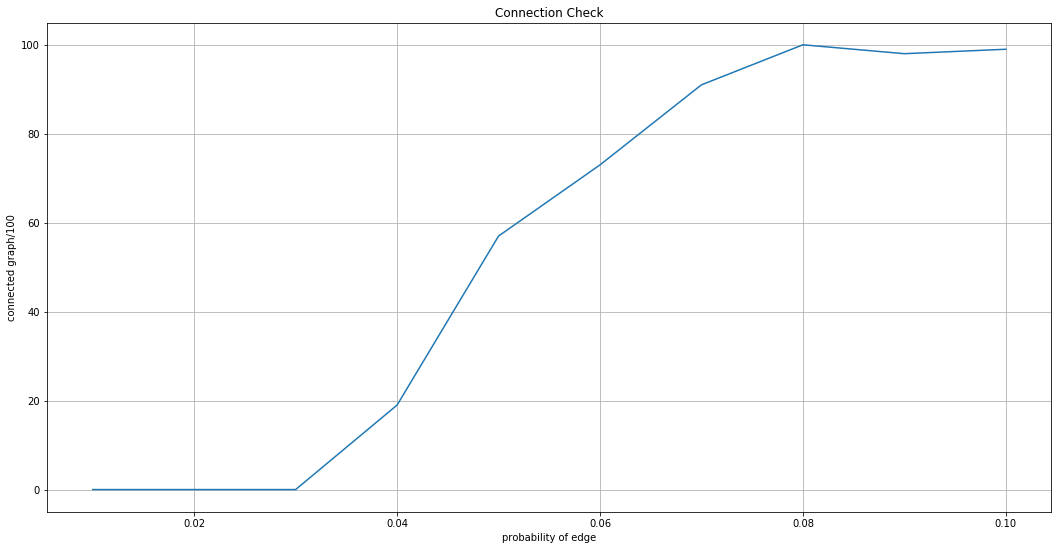

In [33]:
plt.figure(figsize=(18,9))
plt.plot(prob_grid[:10], results[:10])
plt.title('Connection Check')
plt.xlabel('probability of edge')
plt.ylabel('connected graph/100')
plt.grid()

plt.show()

##### Plot of RR and P(connected) wrt r and n with Irreducibility

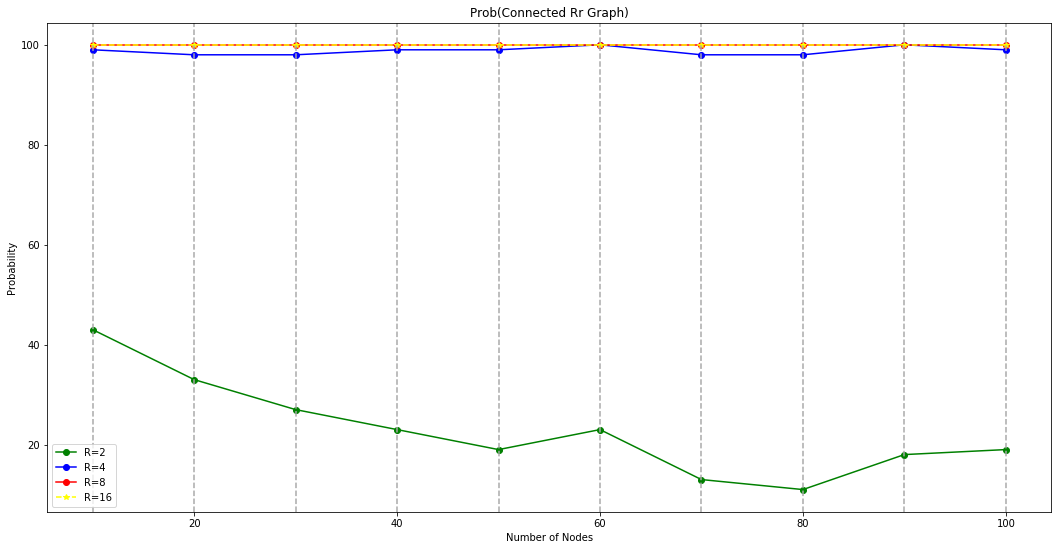

In [34]:
draw_subplot4("Prob(connected RR graph)", "Number of Nodes", "Probability", 
              nodes_grid, 
              results_rr[0], "r=2", 
              results_rr[1], "r=4", 
              results_rr[2], "r=8", 
              results_rr[3], "r=16")

#### Assignment 2

##### 1)

In [35]:
info= my_information(ER)

if (info["connected"]):
    print("The graph is connected")
else:
    print("The graph is not connected")
    
print("average path length: ", info["average_path_length"])

The graph is connected
average path length:  1.9053061224489796


In [36]:
x = int(input("Tell me the source: "))
y = int(input("Tell me the destination: "))
tell_me_the_path(x,y, info)

Tell me the source: 0
Tell me the destination: 5
For going from  0  to  5  you should follow this path:  [0, 24, 5]


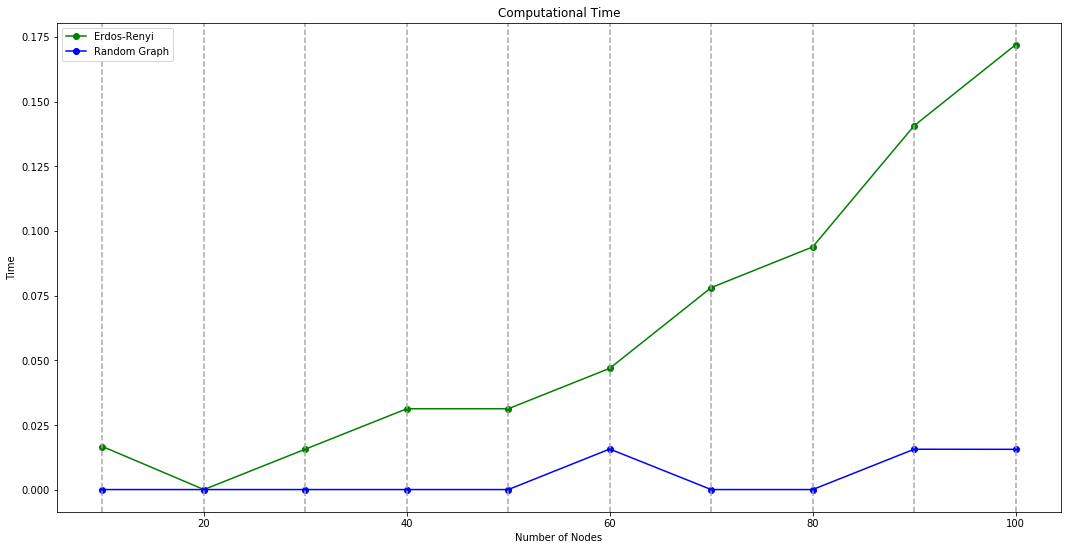

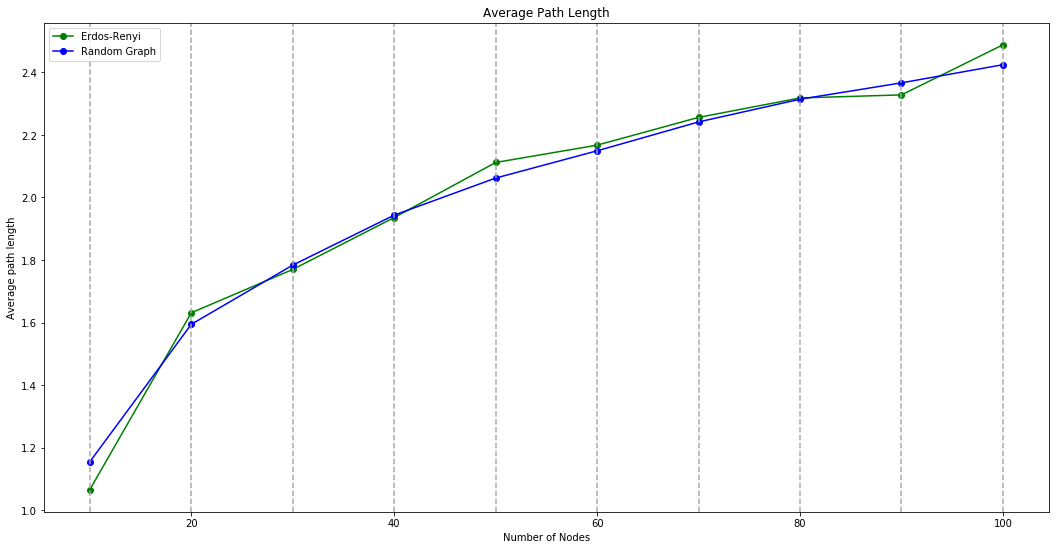

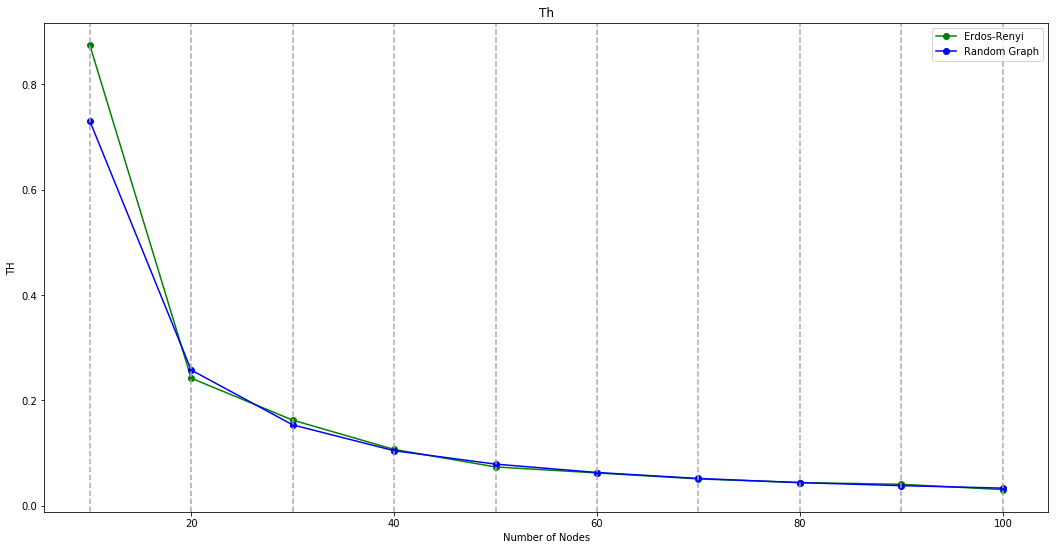

average of h in E:  2.0072983949003875
average of h in R:  2.0034850023128605


In [37]:
# compare computational time, average path lengths and TH of Erdos-Renyi and Random Graph

E_TH = []
R_TH = []
E_time = []
R_time = []
E_path = []
R_path=[]

n_list = np.arange(10,110,10)

for i in n_list:
    # n of flows
    v = i*(i-1)/2
    
    stime = time.time()
    g = erdos_renyi(n=i,p=8/(i-1))
    etime = time.time() - stime
    
    # building all the info of the graph g
    info_e=my_information(g)
    
    h1= info_e["average_path_length"]
    m1 = info_e["links"]
    E_path.append(h1)
    E_time.append(etime)
    E_TH.append(m1/(h1*v))
    

    stime2 = time.time()
    random = rr_graph(i, 8)
    etime2 = time.time() - stime2
    # building all the info of the graph random
    info_r=my_information(random)
    
    h2= info_r["average_path_length"]
    m2 = info_r["links"]
    R_path.append(h2)
    R_time.append(etime2)
    R_TH.append(m2/(h2*v))
    
# plot the computational time    
draw_subplot("Computational time", "Number of Nodes", "Time",
             n_list,
             E_time, "Erdos-Renyi", 
             R_time, "Random graph")

# plot the average path lengths
draw_subplot("Average path length", "Number of Nodes", "Average path length",
             n_list,
             E_path, "Erdos-Renyi", 
             R_path, "Random graph")

# plot the TH
draw_subplot("TH", "Number of Nodes", "TH",
             n_list,
             E_TH, "Erdos-Renyi", 
             R_TH, "Random graph")

print("average of h in E: ", np.mean(E_path))
print("average of h in R: ", np.mean(R_path))

In [45]:
E = []
mE = []
aplE = []
R = []
mR = []
aplR = []

n = 100
q_grid = np.arange(0, 0.3, 0.05)

v = n*(n-1)/2

g = nx.erdos_renyi_graph(n=n,p=8/(n-1))
info_e=my_information(g)
h1= info_e["average_path_length"]
aplE.append(h1)
m1 = info_e["links"]
mE.append(m1)
E.append((4*n)/(h1*v)) 

random = nx.random_regular_graph(d=8, n=n)
info_r=my_information(random)
h2= info_r["average_path_length"]
aplR.append(h2)
m2 = info_r["links"]
mR.append(m2)
R.append((4*n)/(h2*v)) 
       

for i in q_grid[1:]:
    
    g_aux = failure(g,i,n)
    info_e2=my_information(g_aux)
    h1_aux= info_e2["average_path_length"]
    aplE.append(h1_aux)
    m1_aux = info_e2["links"]
    mE.append(m1_aux)
    E.append(m1_aux/(h1_aux*v))
    
    random_aux = failure(random,i,n)
    info_r_aux=my_information(random_aux)
    h2_aux= info_r_aux["average_path_length"]
    aplR.append(h2_aux)
    m2_aux = info_r_aux["links"]
    mR.append(m2_aux)
    R.append(m2_aux/(h2_aux*v))


In [46]:
print(v)

4950.0


In [47]:
#E
print(mE)
print(aplE)
#print(aplE)

[363, 348, 326, 318, 291, 275]
[2.5214141414141413, 2.571111111111111, 2.656767676767677, 2.665429808286951, 2.766439909297052, 2.8686868686868685]


In [48]:
R
print(mR)
print(aplR)

[400, 376, 357, 338, 320, 303]
[2.4216161616161616, 2.478181818181818, 2.5157575757575756, 2.5935353535353536, 2.6533333333333333, 2.7232323232323234]


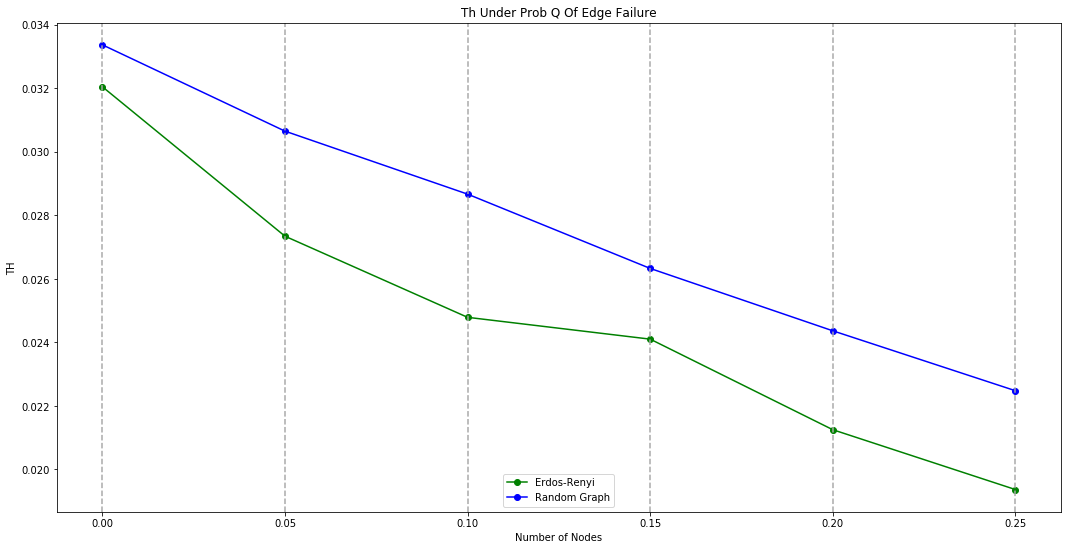

In [49]:
#fig, ax = plt.subplots(figsize=(18,9))
#ax.plot(q_grid, E, label="ER", marker="o", color="green")
#ax.plot(q_grid, R, label="RR", marker="o", color="blue")

#ax.set(xlabel="Probability of failure q", ylabel="TH", title="throughput under failure q")
#plt.legend()
#for number in q_grid:
#    plt.axvline(x=number, color="darkgrey", linestyle="dashed")
#plt.show()
# plot the TH
draw_subplot("TH under prob q of edge failure", "Number of Nodes", "TH",
             q_grid,
             E, "Erdos-Renyi", 
             R, "Random graph")

In [43]:
eall = time.time()-sall
stopWatch(eall)

0 ; 0 : 14 ; 5
